# Explicit time integration basics

_Highlights_
- the basics of time integration with Spitfire

## Introduction

This notebook demonstrates the use of Spitfire's time integration framework, notably its default solver and the use of explicit Runge-Kutta methods. We also compare to the use of `scipy.integrate.odeint`, another convenient ODE solver.

In this first example we solve a simple ordinary differential equation,

$$ \frac{\mathrm{d}y}{\mathrm{d}t} = -ky $$

subject to initial condition $y(0) = y_0$ with real coefficient $k>0$. This has the exact solution, $y(t)=y_0 \exp(-kt)$. This is a simple differential equation but is the fundamental building block of more complicated systems.

## Solving with Spitfire's `odesolve` and SciPy's `integrate.odeint`

First we use `odesolve`, a Spitfire method that drives all the various types of time integration in Spitfire, from the simple Forward Euler method to adaptive time-stepping with high-order implicit Runge-Kutta methods. This method may be used with default settings for many small-scale ODE systems like the above exponential decay or ecology models and simple chemistry models.

In [8]:
import numpy as np
import matplotlib.pyplot as plt

from spitfire import odesolve

Next we set up some of the problem details, like the time step, $k$ value, final time, and initial condition $y_0$, which you'll note is made as a `NumPy` array.

Here we also make a function that computes the right-hand side of the differential equation given the current time and solution value, respectively, as inputs.
Any callable object - something that has a `()` operator that takes two arguments, namely the time and the solution state - can be used as the right-hand side operator.

In [9]:
dt = 0.02
tf = 1.0
k = -10.
y0 = np.array([1.])

rhs = lambda t, y: k * y

Now to use Spitfire's default solver and obtain the solution at the specified set of times (possibly doing many more time steps of variable size behind the scenes, we use the following call to `odesolve`:

In [10]:
output_times = np.linspace(0., tf, 21)
y_default = odesolve(rhs, y0, output_times)

By comparison, see the use of SciPy's `integrate.odeint` method below. Note that SciPy takes the opposite convention that the state vector comes before the solution time in the arguments to the right-hand side function. The `lambda` function below simply switches the argument ordering for SciPy.

In [11]:
from scipy import integrate as scipy_integrate

rhs_for_scipy = lambda x, t: rhs(t, x)

y_scipy = scipy_integrate.odeint(rhs_for_scipy, y0, output_times)

## Using Forward Euler and RK4 in `odesolve`

Now we show how to use Spitfire to use some explicit Runge-Kutta methods it provides for you. Other methods are provided as well, and in following demonstrations we will show how to write your own methods for use with `odesolve`.

- `ForwardEuler`: [the simplest time-stepping method of all](https://en.wikipedia.org/wiki/Euler_method)
- `ExplicitRungeKutta4Classical`: [_the_ Runge Kutta method](https://en.wikipedia.org/wiki/Runge–Kutta_methods), a four-stage, fourth-order method

Note below that two changes are needed to run the explicit methods.

1. We provide the `method` keyword argument to `odesolve`. Carefully note that we are constructing an object with the parentheses after `ForwardEuler`.
2. With these methods we have to tell Spitfire how large the time step is. The default method uses advanced adaptive time-stepping approaches, while here we simply use a constant time step by providing a number to the `step_size` keyword argument.

In [12]:
from spitfire import ForwardEuler, ExplicitRungeKutta4Classical

y_fe = odesolve(rhs, y0, output_times, step_size=dt, method=ForwardEuler())
y_rk = odesolve(rhs, y0, output_times, step_size=dt, method=ExplicitRungeKutta4Classical())

We show one more example in this demonstration. Below we use `odesolve` with the `save_each_step` argument instead of providing an array of output times as above. When this is used, the time and state vector at every time step taken under the hood of `odesolve` are returned. This can be more generally useful when a good array of `output_times` is unclear. Note that it can also generate a lot of data for long-running simulations.

Another key difference is that without `output_times` it's not specified how the simulation should actually terminate.  So, we add the `stop_at_time` argument to integrate only until the final time is reached. Other stopping criteria will be introduced in later demonstrations - as will the ability to write your own entirely customized stopping criteria.

In [13]:
t_fe_full, y_fe_full = odesolve(rhs, y0, stop_at_time=tf, save_each_step=True, step_size=dt, method=ForwardEuler())
t_rk_full, y_rk_full = odesolve(rhs, y0, stop_at_time=tf, save_each_step=True, step_size=dt, method=ExplicitRungeKutta4Classical())

Plotting the results shows that the Forward Euler method, as is expected, is quite inaccurate compared to the other methods. The default integrators in Spitfire and Scipy both yield excellent solutions to this problem. To see in more detail you can zoom in on the plot, thanks to the `%matplotlib notebook` magic.

<IPython.core.display.Javascript object>


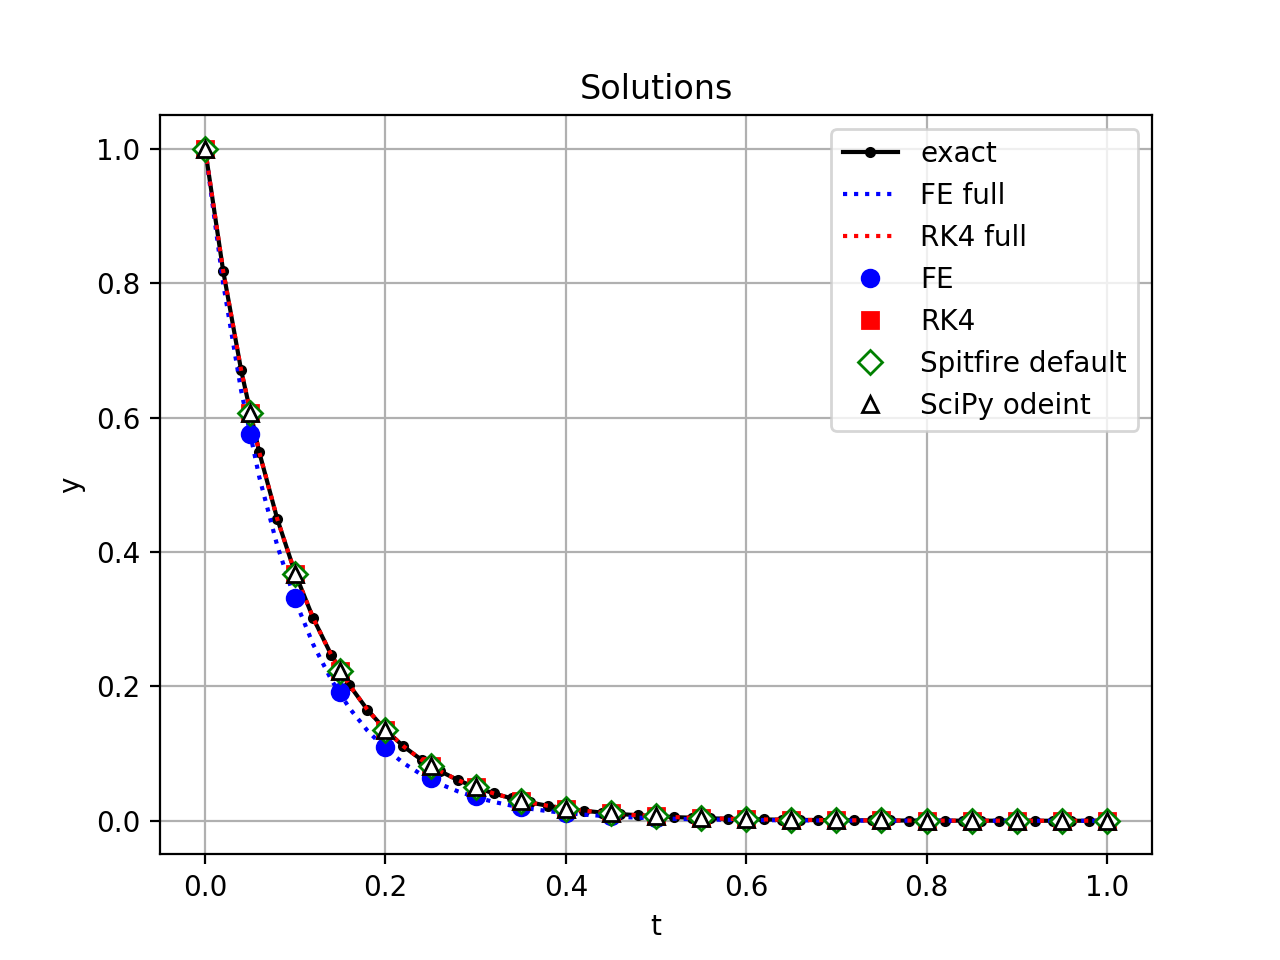

In [14]:
%matplotlib notebook

y_exact = y0 * np.exp(k * t_fe_full)

plt.plot(t_fe_full, y_exact, 'k.-', label='exact')
plt.plot(t_fe_full, y_fe_full, 'b:', label='FE full')
plt.plot(t_rk_full, y_rk_full, 'r:', label='RK4 full')
plt.plot(output_times, y_fe, 'bo', label='FE')
plt.plot(output_times, y_rk, 'rs', label='RK4')
plt.plot(output_times, y_default, 'gD', markerfacecolor='w', label='Spitfire default')
plt.plot(output_times, y_scipy, 'k^', markerfacecolor='w', label='SciPy odeint')

plt.title('Solutions')
plt.xlabel('t')
plt.ylabel('y')
plt.legend(loc='best')
plt.grid()
plt.show()

## Conclusions

In this example we've shown how to use two common time-stepping schemes with Spitfire to solve a simple ordinary differential equation. We've covered how to use the `odesolve` method to drive the time-stepping loop and save data at particular solution times. This can be quite similar to other ODE solvers, such as those in Matlab or SciPy's `integrate.odeint` method. While `odesolve` provides a convenient interface for simple ODEs like this, it allows a great deal of extensibility and fine-grained control over the use of advanced steppers, linear and nonlinear solvers, step controllers, data output, and more. This enables `odesolve` to efficiently solve much more complicated ODE/PDE problems where default solver choices can be infeasibly slow.